In [ ]:
pip install openseespy

## **Modeling this Turbine**
**65-kW Wind Turbine courtesy of UCSD**
<img src='Research\Turbine.PNG' width="300" height="300">

In [1]:
# following example on http://opensees.berkeley.edu/wiki/index.php/Elastic_Frame_Example
# running dynamic ground motion

%matplotlib notebook

# import OpenSees and libraries
from openseespy.opensees import *
from openseespy.postprocessing.Get_Rendering import *

# numerical and plotting tools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import math
from math import sqrt
import pandas as pd
import csv

# system commands
import os, os.path
import glob
import shutil

In [2]:
def buildmodel():

    # -------------------------------
    #       Generate Model
    # -------------------------------

    # remove existing model
    wipe()

    # remove existing results
    # explanation here: https://stackoverflow.com/a/31989328
    def remove_thing(path):
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.remove(path)

    def empty_directory(path):
        for i in glob.glob(os.path.join(path, '*')):
            remove_thing(i)

    empty_directory('modes')
    empty_directory('output')

    # ---------------------------------------
    #   Generate model and static analysis
    # ---------------------------------------

    # set modelbuilder
    model('basic', '-ndm', 3, '-ndf', 6)

    # units: in, kip, s
    # dimensions
    ft = 12.0
    inch = 1.0
    g = 386.1 #in/s^2
    kip = 1.0
    ksi = kip/(inch**2)
    s = 1

    # material properties
    Es = 29000*ksi
    Gs = 11500*ksi

    # -------------------------------
    #       Create Nodes
    # -------------------------------
    # command: node(nodeID, x-coord, y-coord, z-coord)
    # command: node(nodeTag, *crds, '-ndf', ndf, '-mass', *mass, '-disp', *disp, '-vel', *vel, '-accel', *accel)
    # Note: Ian Prowell Dissertation: Split into 30 beam-column elements

    # specify number of elements of each portion of the tower
    eldiv = 6

    # Defining the first node
    nodeTag = 1
    node(nodeTag, 0.0, 0.0, 0.0)

    # Heights of tower sections
    hbot = 238.2*inch
    hbottap = 74.8*inch
    hmid = 237.2*inch
    hmidtap = 74.8*inch
    htop = 263*inch # to reach the top of the nacelle 238 og 

    # Lower tower section (Split into eldiv elements)
    for j in range(eldiv):
        nodeTag += 1
        h = (hbot/eldiv)*(j + 1)
        node(nodeTag, 0.0, 0.0, h)

    # Tapered lower section (Split into eldiv elements)
    for j in range(eldiv):
        nodeTag += 1
        h = hbot + (hbottap/eldiv)*(j + 1)
        node(nodeTag, 0.0, 0.0, h)

    # Middle tower section (Split into eldiv elements)
    for j in range(eldiv):
        nodeTag += 1
        h = hbot + hbottap + (hmid/eldiv)*(j + 1)
        node(nodeTag, 0.0, 0.0, h)

    # Tapered middle section (Split into eldiv elements)
    for j in range(eldiv):
        nodeTag += 1
        h = hbot + hbottap + hmid + (hmidtap/eldiv)*(j + 1)
        node(nodeTag, 0.0, 0.0, h)

    # Top tower section (Split into eldiv elements)
    for j in range(eldiv):
        nodeTag += 1
        h = hbot + hbottap + hmid + hmidtap + (htop/eldiv)*(j + 1)
        node(nodeTag, 0.0, 0.0, h)

    # restraints
    # command: fix(nodeID, DOF1, DOF2, DOF3, DOF4, DOF5, DOF6) 0 = free, 1 = fixed
    # Use a fixed connection for now
    fix(1, 1, 1, 1, 1, 1, 1)

    # geometric transformation for beam-columns
    # command: geomTransf('Type', TransfTag)
    # see https://opensees.berkeley.edu/wiki/index.php/Linear_Transformation 
    geomTransf('PDelta', 1, 0, 1, 0) #columns

    # -------------------------------
    #       Define Elements
    # -------------------------------

    # initialize lists
    D = [] # diameters in
    A = [] # areas in^2
    I = [] # area moment of inertia in^4
    J = [] # polar moment of inertia in^4
    dM = [] # distributed masses kip*s^2/in
    V = [] # volumes in^3
    H = [] # height of each element in
    t = 0.21*inch # thickness is constant


    # Determining the diameters, areas, area moment of inertias, and polar moments of each discretized tower segment
    # diameters of tower
    dbot = 78.7*inch
    dmid = 62.9*inch
    dtop = 47.2*inch

    index = 0

    # Lower tower section (Split into eldiv elemenets)
    for j in range(eldiv):
        H.append(hbot/eldiv)
        D.append(dbot)
        A.append(((D[index])**2 - (D[index] - (2*t))**2)*math.pi/4)
        I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
        J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
        index += 1

    # Tapered lower section (Split into eldiv elements)
    for j in range(eldiv):
        H.append(hbottap/eldiv)
        d = ((j + 1)/(2*eldiv))*(dmid-dbot) + dbot # interpolating for the diameter based on eldiv
        D.append(d)
        A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
        I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
        J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
        index += 1

    # Middle tower section (Split into eldiv elements)
    for j in range(eldiv):
        H.append(hmid/eldiv)
        D.append(dmid)
        A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
        I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
        J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
        index += 1

    # Tapered middle section (Split into eldiv elements)
    for j in range(eldiv):
        H.append(hmidtap/eldiv)
        d = ((j + 1)/(2*eldiv))*(dtop-dmid) + dmid # interpolating for the diameter based on eldiv
        D.append(d)
        A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
        I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
        J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
        index += 1

    # Top tower section
    for j in range(eldiv):
        H.append(htop/eldiv)
        D.append(dtop)
        A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
        I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
        J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
        index += 1

    # Determining volumes of tower segments
    index = 0

    # Lower tower section (Split into eldiv elemenets)
    for j in range(eldiv):
        v = math.pi*(hbot/eldiv)*(D[index]**2 - (D[index]-2*t)**2)/4
        V.append(v)
        index += 1

    # Tapered lower section (Split into eldiv elements)
    for j in range(eldiv):
        dlower = ((dmid-dbot)*j)/(eldiv) + dbot
        dhigher = ((dmid-dbot)*(j+1))/(eldiv) + dbot
        v = math.pi*(hbottap/eldiv)*((dlower**2 +dlower*dhigher + dhigher**2)-((dlower-2*t)**2 + (dlower-2*t)*(dhigher-2*t) + (dhigher-2*t)**2))/12
        V.append(v)
        index += 1    

    # Middle tower section (Split into eldiv elements)
    for j in range(eldiv):
        v = math.pi*(hmid/eldiv)*(D[index]**2 - (D[index]-2*t)**2)/4
        V.append(v)
        index += 1

    # Tapered middle section (Split into eldiv elements)
    for j in range(eldiv):
        dlower = ((dtop-dmid)*j)/(eldiv) + dmid
        dhigher = ((dtop-dmid)*(j+1))/(eldiv) + dmid
        v = math.pi*(hmidtap/eldiv)*((dlower**2 +dlower*dhigher + dhigher**2)-((dlower-2*t)**2 +(dlower-2*t)*(dhigher-2*t) + (dhigher-2*t)**2))/12
        V.append(v)
        index += 1    

    # Top tower section (Split into eldiv elements)
    for j in range(eldiv):
        v = math.pi*(htop/eldiv)*(D[index]**2 - (D[index]-2*t)**2)/4
        V.append(v)
        index += 1


    mtotal = 14.101*kip/g
    vtotal = sum(V)
    htotal = hbot + hbottap + hmid + hmidtap + htop

    # Determining distributed masses of tower segments
    # Entire tower section (Split into 5*eldiv elemenets)
    for j in range(len(H)):
        distm = (mtotal*V[j])/(vtotal*H[j]) # mass/height constant
        dM.append(distm)

    # Defining the elements and determining areas, area moment of inertias, and polar inertias for each section
    # Cylindrical sections => Ix = Iy 
    # Cylindrical sections => J = Iz = 2*Ix = (D^4-(D-t)^4)*(pi/32) 

    # Assigning element properties
    # create elastic beam-column elements - 
    # command: element('elasticBeamColumn', eleTag, *eleNodes, Area, E_mod, G_mod, Jxx, Iy, Iz, transfTag, <'-mass', mass>, <'-cMass'>)
    # define the columns  
    for j in range(len(H)):
        element('elasticBeamColumn', j+1, j+1, j+2, A[j], Es, Gs, J[j], I[j], I[j], 1, '-mass', dM[j])

    # Uncomment to see how the turbine twists
    #node(nodeTag +1, 0.0, 10.0*ft, h)
    #geomTransf('Linear', 2, 0, 0, 1) #columns
    #element('elasticBeamColumn', len(H) + 1, len(H) + 1, len(H) + 2, A[len(H)-2], Es, Gs, J[len(H)-2], I[len(H)-2], I[len(H)-2], 2, '-mass', dM[len(H)-2])

    # assign additional masses
    # masses only act at nodes that have DoF
    # command: mass(nodeID, dx, dy, dz, r@x, r@y, r@z)
    # rotational inertia for a point mass: I = mr^2
    whub = 9.4*kip
    mhub = whub/g #kip*s^2/in
    ### to-do: the box is slightly higher than the last node of the tower, should we add another node? how would it be connected to the rest of the tower?
    hhub = 888*inch # height of hub
    #node(len(H) + 2, 0.0, 0.0, hhub) # CHANGE the top height it this is used
    #rigidLink('beam', len(H)+1, len(H)+2)
    #mass(len(H) + 1, mhub, mhub, mhub, 0.0, 0.0, 0.0)

In [3]:
# units: in, kip, s
# dimensions
ft = 12.0
inch = 1.0
g = 386.1 #in/s^2
kip = 1.0
ksi = kip/(inch**2)
s = 1

# ----------------------------------
#       Define Sinusoidal Loading
# ----------------------------------

# Define parameters of the Sinusoidal Loading

T = 30 #Define how long the loading should go for
dt = 0.001 # Define the time step for input ground motion
tsteps = range(int((T/dt)))

t = [] # Define time list
for i in (tsteps):
    t.append(dt*i)

    
# Wave typical frequency and magnitude
# Define range of forcing frequency f (Hz)
f1 = 0.5/s
f2 = 2/s
df = 0.1 # Define discretization of forcing frequencies 
fsteps = range(int((f2-f1)/df))

# Wind typical frequency and magnitude
# # Define range of forcing frequency f (Hz)
# f1 = 0.05/s
# f2 = 2/s
# df = 0.1 # Define discretization of forcing frequencies 
# fsteps = range(int((f2-f1)/df))

# Blade typical frequency and magnitude
# # Define range of forcing frequency f (Hz)
# f1 = 0.5/s
# f2 = 2/s
# df = 0.1 # Define discretization of forcing frequencies 
# fsteps = range(int((f2-f1)/df))


# -------------------------------
#       Set up Dynamic analysis
# -------------------------------
f = []
peakVx = []
peakVy = []
peakMx = []
peakMy = []
dfVx = pd.DataFrame(index=[t]) # Define dataframe with all Base Shear x data
dfVy = pd.DataFrame(index=[t]) # Define dataframe with all Base Shear y data
dfMx = pd.DataFrame(index=[t]) # Define dataframe with all Overturning Moment about the x axis data
dfMy = pd.DataFrame(index=[t]) # Define dataframe with all Overturning Moment about the y axis data

# # Define a function to return the maximum value of the steady state response
# def eleMax(items, start = 0, end=None):
#     return abs(max(items[start:end], key=abs))

buildmodel() # Build model to determine natural frequency
# --------------------------------
#       Perform eigen analysis
# --------------------------------

numEigen = 30
lameigenValues = eigen(numEigen)

wn = [i ** 0.5 for i in lameigenValues]
fn = [i / (2*math.pi) for i in wn]

print("Natural Frequencies:", fn, "Hz")

# compute the modal properties
#modalProperties("-print", "-file", "ModalReport.txt", "-unorm")

# -------------------------------------------
#       Plotting Structure and Modeshapes
# -------------------------------------------

# Display the active model with node and element tags
#plot_model("nodes","elements")

#plot_modeshape(1, 50)
#plot_modeshape(3, 50)
#plot_modeshape(6, 50)


# set the rayleigh damping factors for nodes & elements
rayleigh(0.0, 0.0, 0.0, 2*0.005/wn[0])

# Looping for each frequency
for i in fsteps:
    buildmodel() # Wipe and build new model for every frequency
    wipeAnalysis() # Wipe any previous pattern
    constraints('Plain')  			# how it handles boundary conditions
    numberer('Plain')
    system('BandGeneral')		    # how to store and solve the system of equations in the analysis
    algorithm('Newton')                 # use Newton-Raphson for linear analysis
    integrator('Newmark', 0.5, 0.25)        # create integration scheme, Newmark with alpha = 0.5, beta = 0.25
    analysis('Transient')      	    # define type of analysis static or transient

    # Create the convergence test, the norm of the residual with a tolerance of
    # 1e-12 and a max number of iterations of 10
    test('NormDispIncr', 1.0e-12,  10 )

# # # Run each ground motion per each frequency wf and extract the maximum moment per each sinusoidal ground motion
    f.append(f1 + (df*i)) # Keeping track of the frequencies
    Vx = [] # Resetting each vector for each frequency
    Vy = []
    Mx = []
    My = []
    setTime(0) # Reset time
    time = []
    
    # Setting up variables for the transient analysis
    tCurrent = getTime()
    tFinal = T
    ok = 0
    # Getting the correct ground motion per frequency step
    timeSeries('Trig', i+1, 0, T, 1/f[i], '-factor', g) 
    # patternTag, direction  accelTag
    pattern('UniformExcitation', i+1, 1, '-accel', i+1) # x direction

    # Perform the transient analysis
    while ok == 0 and tCurrent < tFinal:
        ok = analyze(1, dt)
        if ok != 0:
            print('WARNING' + str(tCurrent) + 'w' + str(i))
        # if the analysis fails try initial tangent iteration
            print("regular newton failed .. let's try an initial stiffness for this step")
            test('NormDispIncr', 1.0e-12,  100, 0)
            algorithm('ModifiedNewton', '-initial')
            ok = analyze(1, dt)
            if ok == 0:
                print("that worked .. back to regular newton")
            test('NormDispIncr', 1.0e-12,  10 )
            algorithm('Newton')
        # Store element forces per time step 
        tCurrent = getTime()
        time.append(tCurrent)     
        Vx.append(eleForce(1, 1)) # Vx
        Vy.append(eleForce(1, 2)) # Vy
        Mx.append(eleForce(1, 4)) # Mx
        My.append(eleForce(1, 5)) # My
    # Post-processing
    #maxVx = eleMax(Vx, int((T/dt)+1) - 20)
    #peakVx.append(maxVx)
    peakVx.append(abs(max(Vx, key=abs)))
    peakVy.append(abs(max(Vy, key=abs)))
    peakMx.append(abs(max(Mx, key=abs)))
    peakMy.append(abs(max(My, key=abs)))
    dfVx['w'+str(i)+"="+str(f[i])] = Vx
    dfVy['w'+str(i)+"="+str(f[i])] = Vy
    dfMx['w'+str(i)+"="+str(f[i])] = Mx
    dfMy['w'+str(i)+"="+str(f[i])] = My
    
dfVx.head(20)


Natural Frequencies: [3.8585364796445374, 3.85853647964454, 17.931219578779764, 17.931219578779768, 45.1468326720981, 45.146832672098135, 54.94899552116684, 90.33117629259102, 90.33117629259341, 144.8779322227062, 146.7393428677584, 146.7393428677586, 217.5535748422115, 217.55357484221233, 232.9887810592697, 303.9778727088799, 303.97787270888074, 339.2654743405079, 402.8693447618276, 402.8693447618311, 428.3551850388858, 511.0369740654948, 521.3346189956088, 521.3346189956122, 610.6208304907273, 638.8713188063718, 638.8713188063736, 694.2962668000375, 765.5910987170997, 779.7665605035721] Hz


,w0=0.5,w1=0.51,w2=0.52,w3=0.53,w4=0.54,w5=0.55,w6=0.56,w7=0.5700000000000001,w8=0.58,w9=0.59,...,w140=1.9000000000000001,w141=1.91,w142=1.92,w143=1.93,w144=1.94,w145=1.95,w146=1.96,w147=1.97,w148=1.98,w149=1.99
0.000,0.004324,0.004411,0.004497,0.004584,0.004670,0.004757,0.004843,0.004930,0.005016,0.005103,...,0.016432,0.016518,0.016605,0.016691,0.016778,0.016864,0.016951,0.017037,0.017124,0.017210
0.001,0.012954,0.013213,0.013472,0.013731,0.013990,0.014249,0.014508,0.014767,0.015026,0.015285,...,0.049220,0.049479,0.049739,0.049998,0.050257,0.050516,0.050775,0.051034,0.051293,0.051552
0.002,0.023761,0.024236,0.024711,0.025186,0.025662,0.026137,0.026612,0.027087,0.027562,0.028038,...,0.090278,0.090753,0.091228,0.091703,0.092178,0.092653,0.093128,0.093603,0.094078,0.094553
0.003,0.036647,0.037380,0.038113,0.038846,0.039579,0.040312,0.041045,0.041778,0.042511,0.043244,...,0.139225,0.139958,0.140690,0.141423,0.142155,0.142887,0.143620,0.144352,0.145084,0.145817
0.004,0.050996,0.052016,0.053035,0.054055,0.055075,0.056095,0.057115,0.058135,0.059155,0.060174,...,0.193709,0.194728,0.195746,0.196765,0.197784,0.198802,0.199821,0.200839,0.201858,0.202877
0.005,0.066599,0.067931,0.069262,0.070594,0.071926,0.073258,0.074590,0.075922,0.077253,0.078585,...,0.252934,0.254264,0.255593,0.256923,0.258252,0.259582,0.260911,0.262241,0.263570,0.264900
0.006,0.083400,0.085068,0.086736,0.088403,0.090071,0.091739,0.093407,0.095074,0.096742,0.098410,...,0.316679,0.318343,0.320007,0.321671,0.323335,0.324999,0.326662,0.328326,0.329990,0.331653
0.007,0.101378,0.103405,0.105432,0.107459,0.109486,0.111514,0.113541,0.115568,0.117595,0.119622,...,0.384852,0.386873,0.388894,0.390915,0.392936,0.394957,0.396978,0.398998,0.401019,0.403040
0.008,0.120401,0.122809,0.125216,0.127624,0.130031,0.132439,0.134846,0.137253,0.139661,0.142068,...,0.456948,0.459347,0.461745,0.464143,0.466541,0.468939,0.471337,0.473735,0.476133,0.478530
0.009,0.140394,0.143202,0.146009,0.148816,0.151623,0.154430,0.157237,0.160044,0.162851,0.165658,...,0.532669,0.535463,0.538257,0.541051,0.543845,0.546638,0.549431,0.552224,0.555018,0.557810


<IPython.core.display.Javascript object>


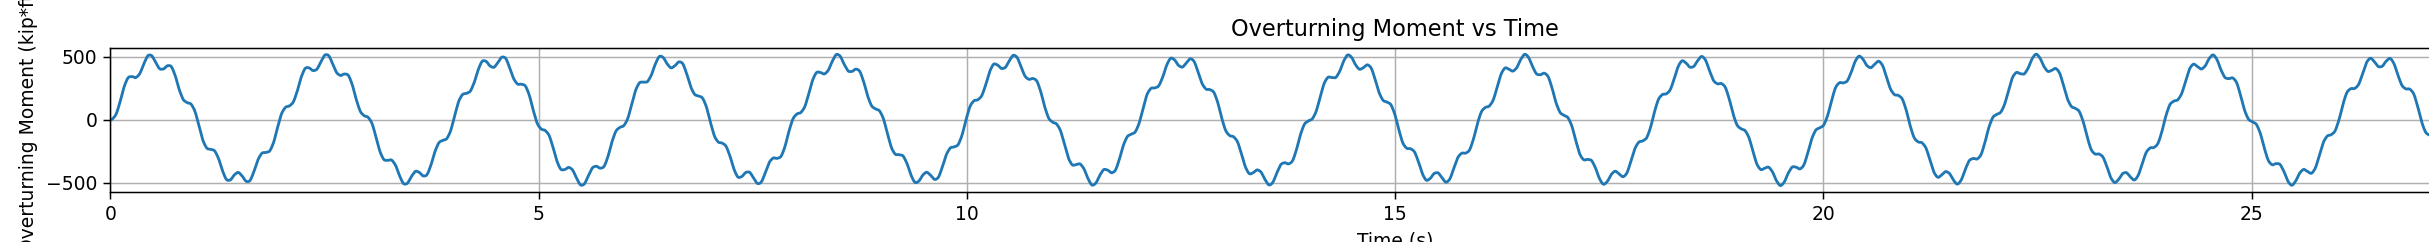

(0.0, 30.0)

In [8]:


#plt.plot(time, dfVx['w1'])
# dfMy.head(30)

#fig, ax = plt.subplots(dpi = 200, figsize=(20,3)) #time
fig, ax = plt.subplots(dpi = 150, figsize=(20,2)) #freq


# plt.plot(time, dfVx.iloc[:,50])
# plt.ylabel('Base Shear (kip)')
# plt.xlabel('Time (s)')
# plt.title('Base Shear vs Time')
# plt.grid(b=True)
# plt.show()

ax.plot(time, dfMy.iloc[:,0]/12)
ax.set_ylabel('Overturning Moment (kip*ft)')
ax.set_xlabel('Time (s)')
ax.set_title('Overturning Moment vs Time')
ax.grid(True)
plt.tight_layout()
plt.xlim([0,T])

# ax.plot(f, peakVx)
# ax.set_ylabel('Peak Base Shear (kip)')
# ax.set_xlabel('Forcing Frequency (Hz)')
# ax.set_title('Peak Base Shear vs Forcing Frequency')
# ax.grid(True)
# plt.tight_layout()
# plt.xlim([0,f2])


# plt.plot(f, peakVx)
# plt.ylabel('Peak Base Shear (kip)')
# plt.xlabel('Frequency (Hz)');


In [5]:


#print(f)
print(peakVx)
#print(peakMy)
#print(f2)




[15.274103519264086, 15.274115120322238, 15.324870918181647, 15.355027598569817, 15.379256878775282, 15.40991804420362, 15.428246974609555, 15.434424798089328, 15.508534878192968, 15.502230136286116, 15.543980391764554, 15.571574653282084, 15.56792155416201, 15.642131250022857, 15.668237644000564, 15.700542536478563, 15.720352963820298, 15.746595523949237, 15.670293896930316, 15.654062332430643, 15.821420249796336, 15.866275322853967, 15.904882294312115, 15.927386147754056, 15.936108607639454, 16.001307809372978, 16.015240982055523, 15.516680270080528, 16.032602278829998, 16.10957413617295, 16.167772383727574, 16.184377898844208, 16.199816637815797, 16.266798229560813, 16.285990532303018, 16.312716728036, 16.36781083943099, 16.390164774042013, 16.393435955364208, 16.46622190693616, 16.49511276250836, 16.534137102777, 16.525824649345672, 16.552105629843417, 16.607686882179987, 16.675550401573382, 16.682242834510916, 16.721560051114565, 16.77719576125181, 16.79653061639197, 16.8195016318

In [ ]:
# 3-D Plotting

#https://stackoverflow.com/questions/51765184/how-to-3d-plot-function-of-2-variables-in-python?noredirect=1&lq=1
#https://stackoverflow.com/questions/45396059/multiple-independent-lines-in-the-same-3d-axes
fig = plt.figure()
ax = fig.gca(projection='3d')

freq = pd.DataFrame(index=[t])

for i in range(20): # all frequencies: len(f)
    freq[i] =  [f[i]] * len(time)
    ax.plot(time,freq[i], dfVx.iloc[:,i])
    

# make labels
ax.set_xlabel('Time (s)')
ax.set_ylabel('Forcing Frequency (Hz)')
ax.set_zlabel('Base Shear (kip)')

plt.show()

In [ ]:
# 3-D Plotting Surface

#https://stackoverflow.com/questions/12423601/simplest-way-to-plot-3d-surface-given-3d-points
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
import numpy
from numpy.random import randn
from scipy import array, newaxis

Vx3dall = []
Vx3d = []

for i in range(200): #len(f)
    for j in range(20000): #len(time)
        Vx3d = [time[j], f[i], dfVx.iat[j,i]]
        Vx3dall.append(Vx3d)

DATA = array(Vx3dall)
Xs = DATA[:,0]
Ys = DATA[:,1]
Zs = DATA[:,2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(Xs, Ys, Zs, cmap=cm.jet, linewidth=0)
fig.colorbar(surf)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

# make labels
ax.set_xlabel('Time (s)')
ax.set_ylabel('Forcing Frequency (Hz)')
ax.set_zlabel('Base Shear (kip)')

fig.tight_layout()

plt.show()
# Test commit